In [1]:
## compare the impact of the one-body decaying DM parameters in 
# - CLASS (linear) 
# - CLASS (non-linear) 
# - emulator from Jonathan Hubert et al., JCAP10(2021)040

In [2]:
### import relevant modules
from classy import Class
import numpy as np
from matplotlib import pyplot as plt

## Unit conversion factor for decay rate

In [3]:
### Run this only if you need to do unit conversions

#### Converting the value of Gamma to km/s/Mpc
from astropy import units as u

### Set the value below
gamma_value = 1     # in units Gyr**(-1)

### Conversion takes place below
(gamma_value*u.Gyr**(-1)).to(u.km/u.Mpc/u.s)

<Quantity 977.79222168 km / (Mpc s)>

## Class

In [4]:
### choose common settings
Omega_m = 0.307
Omega_b = 0.048
A_s=2.43e-9
h = 0.678
n_s = 0.96
f = 0.4      # fraction of DDM
gamma=1/31.6 # decay rate in 1/Gyr

# redhsift and maximum k in the plots
kmax = 3
z=0

# derived parameters
omega_b  = Omega_b*h**2
Omega_dm = Omega_m-Omega_b
omega_dm = Omega_dm*h**2

common_settings={ 
                    'output' : 'mPk',
                    'non linear' : 'halofit',
                    'P_k_max_h/Mpc' : kmax,
                    'h' : h,
                    'omega_b' : omega_b,
                    'n_s' : n_s,
                    'A_s' : A_s,
                    'z_reio' : 9.9
                }

kk = np.logspace(np.log10(1e-3),np.log10(1),1000)

In [5]:
### compute P_LCDM^NL(k,z)
lcdm = Class()
lcdm.set(common_settings)
lcdm.set({'omega_cdm' : omega_dm})
lcdm.compute()
pk_cdm = np.vectorize(lcdm.pk)(kk,z)
pk_cdm_lin = np.vectorize(lcdm.pk_lin)(kk,z)

In [6]:
### compute P_DDM^NL(k,z) from CLASS
ddm = Class()
ddm.set(common_settings)
ddm.set({
        #'omega_dcdmdr' : f*omega_dm,
        'omega_ini_dcdm' : f*omega_dm,
        'omega_cdm'    : omega_dm*(1.-f),
        'Gamma_dcdm'   : 9.777922e2*gamma
        })
ddm.compute()
pk_ddm = np.vectorize(ddm.pk)(kk,z)
pk_ddm_lin = np.vectorize(ddm.pk_lin)(kk,z)

## Emulator

In [7]:
### This function predicts epsilon = 1-P_DDM^NL(k,z)/P_LCDM^NL(k,z) for each Gamma_DDM and f_DDM
### The comsological parameters are passed through the cosmo class
def epsilon_nonlin(cosmo,𝛤,f,k,z):

    h = cosmo.h()
    omega_m = cosmo.Omega_m()*h**2
    omega_b = cosmo.omega_b()
    u = omega_b/0.02216
    v = h/0.6776
    w = omega_m/0.14116

    a = 0.7208 + 2.027 * 𝛤 + 3.0310*(1/(1+1.1*z))-0.18
    b = 0.0120 + 2.786 * 𝛤 + 0.6699*(1/(1+1.1*z))-0.09
    p = 1.045 + 1.225  * 𝛤 + 0.2207*(1/(1+1.1*z))-0.099
    q = 0.9922 + 1.735 * 𝛤 + 0.2154*(1/(1+1.1*z))-0.056
    
    alpha = (5.323 - 1.4644*u - 1.391*v) + (-2.055+1.329*u+0.8673*v)*w + (0.2682-0.3509*u)*w**2
    beta  = (0.9260) + (0.05735 - 0.02690*v)*w + (-0.01373 + 0.006713*v)*w**2
    gamma = (9.553 - 0.7860*v)+(0.4884+0.1754*v)*w + (-0.2512+0.07558*v)*w**2

    epsilon_lin = alpha * (𝛤)**beta * (1/(0.105*z + 1))**gamma
    ratio = (1+a*k**p)/(1+b*k**q)*f

    return epsilon_lin * ratio

## Plotting

### Fitting function

The fitting function we are given in the paper is the following,
$$ P_{DDM}/P_{CDM} = 1- \epsilon_{non lin} (k) $$

Below we below plot all the different plots which can be studied.

In [8]:
## General plot settings to be used for all plots
def plot_settings(x) :
    return x.legend(fontsize=13),x.set_xlabel('k [1/Mpc]',fontsize=14)

Text(0, 0.5, '$ \\mathrm{P_{DDM}(k)/P_{CDM}(k)} $')

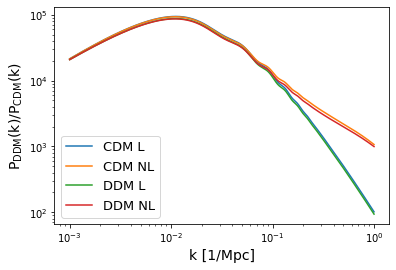

In [9]:
## Plotting the CLASS power spectra

fig,ax = plt.subplots(nrows=1,ncols=1)
ax.loglog(kk,pk_cdm_lin, label='CDM L')
ax.loglog(kk,pk_cdm, label='CDM NL')
ax.loglog(kk,pk_ddm_lin, label='DDM L')
ax.loglog(kk,pk_ddm, label='DDM NL')
plot_settings(ax)
ax.set_ylabel(r'$ \mathrm{P_{DDM}(k)/P_{CDM}(k)} $',fontsize=14)

Text(0, 0.5, '$ \\mathrm{P_{DDM}(k)/P_{CDM}(k)} $')

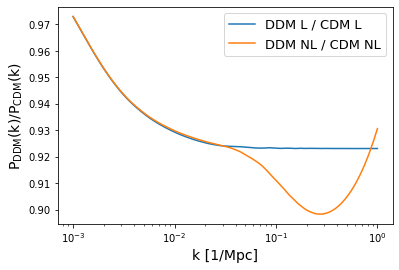

In [10]:
## Plotting the CLASS linear and non linear power spectrum ratios w.r.t CDM

fig,ax = plt.subplots(nrows=1,ncols=1)
ax.semilogx(kk,pk_ddm_lin/pk_cdm_lin, label='DDM L / CDM L')
ax.semilogx(kk,pk_ddm/pk_cdm,label='DDM NL / CDM NL')
plot_settings(ax)
ax.set_ylabel(r'$ \mathrm{P_{DDM}(k)/P_{CDM}(k)} $',fontsize=14)

Below we plot and compare $P_{DDM}$ and $ P_{CDM} \cdot (1 - \epsilon_{non lin}(k))$

(<matplotlib.legend.Legend at 0x138d11100>, Text(0.5, 0, 'k [1/Mpc]'))

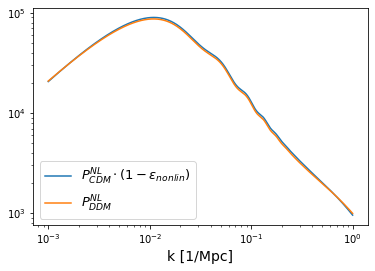

In [11]:
fig,ax = plt.subplots(nrows=1,ncols=1)
ax.loglog(kk,pk_cdm*(1-epsilon_nonlin(lcdm,gamma,f,kk,z)),label=r'$P_{CDM}^{NL} \cdot (1-\epsilon_{non lin})$')
ax.loglog(kk,pk_ddm, label=r'$P_{DDM}^{NL}$')
plot_settings(ax)

Below we plot the ratio $P_{DDM} / P_{CDM}$ and $ 1 - \epsilon_{non lin}(k)$

(<matplotlib.legend.Legend at 0x138d11f70>, Text(0.5, 0, 'k [1/Mpc]'))

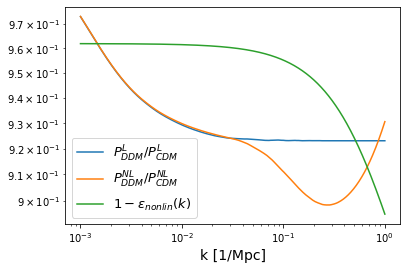

In [12]:
fig,ax = plt.subplots(nrows=1,ncols=1)
ax.loglog(kk,pk_ddm_lin/pk_cdm_lin, label = r'$P_{DDM}^{L} / P_{CDM}^{L}$')
ax.loglog(kk,pk_ddm/pk_cdm, label = r'$P_{DDM}^{NL} / P_{CDM}^{NL}$')
ax.loglog(kk,(1-epsilon_nonlin(lcdm,gamma,f,kk,z)),label=r'$1-\epsilon_{non lin} (k)$')
plot_settings(ax)

Below we plots the ratio $P_{DDM}/P_{CDM} \cdot 1/(1- \epsilon_{non lin} (k)) = 1 $

(<matplotlib.legend.Legend at 0x138fa90d0>, Text(0.5, 0, 'k [1/Mpc]'))

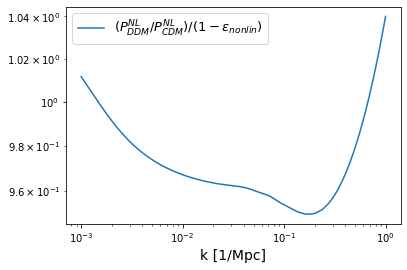

In [13]:
fig,ax = plt.subplots(nrows=1,ncols=1)
ax.loglog(kk,pk_ddm/pk_cdm/(1-epsilon_nonlin(lcdm,gamma,f,kk,z)),
                            label = r'$(P_{DDM}^{NL} / P_{CDM}^{NL})/(1-\epsilon_{non lin})$')
plot_settings(ax)

## Cosmological parameters for reference

In [ ]:
lcdm.Omega_b(),lcdm.Omega0_cdm(),lcdm.Omega0_m(),lcdm.h()

In [ ]:
ddm.Omega_b(),ddm.Omega0_cdm(),ddm.Omega0_m(),ddm.h()